In [1]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import bisect

%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
compressCombined = pd.read_csv('compressCombined.out', sep='\t', header=None)

In [3]:
#header = ['term', 'Uncompress', 'Ones', 'UncompressWoOnes', 'Compress', 'CompressWoOnes']
header = ['term', 'Li', '1s', 'ar1l', 'Li_wo_1', 'C_Li', 'C_Li_wo_1', 'Len_bitmap', 'bitmap1s']
compressCombined.columns = header

In [32]:
#compressCombined.describe()
compressCombined['Len_bitmap_un'] = compressCombined.Li / 8 + 1
compressCombined['Li_x4'] = compressCombined.Li * 4
compressCombined['Li_wo_1_x4'] = compressCombined.Li_wo_1 * 4
compressCombined['C_Li_x4'] = compressCombined.C_Li * 4
compressCombined['C_Li_wo_1_x4'] = compressCombined.C_Li_wo_1 * 4

compressCombined['C_Ratio_Li'] = compressCombined.C_Li_x4 / compressCombined.Li_x4
compressCombined['C_Ratio_Li_wo_1'] = compressCombined.C_Li_wo_1_x4 / compressCombined.Li_wo_1_x4

In [33]:
compressCombined['Combined_Un'] = (compressCombined.Li_wo_1_x4 + compressCombined.Len_bitmap_un)/compressCombined.Li_x4
compressCombined['Combined_Co'] = (compressCombined.C_Li_wo_1_x4 + compressCombined.Len_bitmap)/compressCombined.C_Li_x4

In [34]:
compressCombined[compressCombined.columns[1:]]
#compressCombined[compressCombined.columns[1:]].describe()
#compressCombined['C_Li'].sum()
#compressCombined[['Combined_Co', 'Combined_Un']]
#compressCombined[compressCombined.columns[1:]]
#compressCombined[compressCombined['Li'] == 1]

,Li,1s,ar1l,Li_wo_1,C_Li,C_Li_wo_1,Len_bitmap,bitmap1s,Len_bitmap_un,Li_x4,Li_wo_1_x4,C_Li_x4,C_Li_wo_1_x4,Combined_Un,Combined_Co,C_Ratio_Li,C_Ratio_Li_wo_1
0,984654,93752,1.177,890902,172285,159533,119016,93752,123082.750,3938616,3563608,689140,638132,0.936,1.099,0.175,0.179
1,11367,9,1.000,11358,3847,3850,72,9,1421.875,45468,45432,15388,15400,1.030,1.005,0.338,0.339
2,76412,625,1.023,75787,20284,20238,2788,625,9552.500,305648,303148,81136,80952,1.023,1.032,0.265,0.267
3,7493,218,5.450,7275,2612,2587,76,218,937.625,29972,29100,10448,10348,1.002,0.998,0.349,0.356
4,4883,4,1.000,4879,1962,1960,32,4,611.375,19532,19516,7848,7840,1.030,1.003,0.402,0.402
5,3867,4,1.000,3863,1580,1593,32,4,484.375,15468,15452,6320,6372,1.030,1.013,0.409,0.412
6,4494,8,1.000,4486,1730,1748,40,8,562.750,17976,17944,6920,6992,1.030,1.016,0.385,0.390
7,4887,1,1.000,4886,1790,1799,8,1,611.875,19548,19544,7160,7196,1.031,1.006,0.366,0.368
8,4089,123,3.237,3966,1667,1661,56,123,512.125,16356,15864,6668,6644,1.001,1.005,0.408,0.419
9,4095,1,1.000,4094,1568,1559,8,1,512.875,16380,16376,6272,6236,1.031,0.996,0.383,0.381


In [7]:
vectorize = np.vectorize(lambda x: 1 - x) # 1 - x = Compression Ratio #
combinedUncompressArrayWin = vectorize(np.array(compressCombined[compressCombined['Combined_Un'] < 1.0]['Combined_Un']))
combinedCompressArrayWin = vectorize(np.array(compressCombined[compressCombined['Combined_Co'] < 1.0]['Combined_Co']))

combinedUncompressArrayLose = vectorize(np.array(compressCombined[compressCombined['Combined_Un'] >= 1.0]['Combined_Un']))
combinedCompressArrayLose = vectorize(np.array(compressCombined[compressCombined['Combined_Co'] >= 1.0]['Combined_Co']))

In [8]:
bins = np.array((.1, .2, .3, .4, .5, .6, .7, .8, .9, 1.), dtype=np.float64)
frequencyCombinedUncompressWin = np.zeros(10, dtype=np.float64)
frequencyCombinedCompressWin = np.zeros(10, dtype=np.float64)

frequencyCombinedUncompressLose = np.zeros(10, dtype=np.float64)
frequencyCombinedCompressLose = np.zeros(10, dtype=np.float64)

In [10]:
# Interval Type [) #
for idx in xrange(0, combinedUncompressArrayWin.shape[0]):
    frequencyCombinedUncompressWin[bisect.bisect_right(bins, combinedUncompressArrayWin[idx])] += 1
for idx in xrange(0, combinedCompressArrayWin.shape[0]):
    frequencyCombinedCompressWin[bisect.bisect_right(bins, combinedCompressArrayWin[idx])] += 1

frequencyCombinedUncompressWin = (frequencyCombinedUncompressWin / compressCombined['term'].count()) * 100
frequencyCombinedCompressWin = (frequencyCombinedCompressWin / compressCombined['term'].count()) * 100

In [11]:
# Interval Type [) #
for idx in xrange(0, combinedUncompressArrayLose.shape[0]):
    frequencyCombinedUncompressLose[bisect.bisect_right(bins, combinedUncompressArrayLose[idx])] += 1
for idx in xrange(0, combinedCompressArrayLose.shape[0]):
    frequencyCombinedCompressLose[bisect.bisect_right(bins, combinedCompressArrayLose[idx])] += 1

frequencyCombinedUncompressLose = (frequencyCombinedUncompressLose / compressCombined['term'].count()) * 100
frequencyCombinedCompressLose = (frequencyCombinedCompressLose / compressCombined['term'].count()) * 100

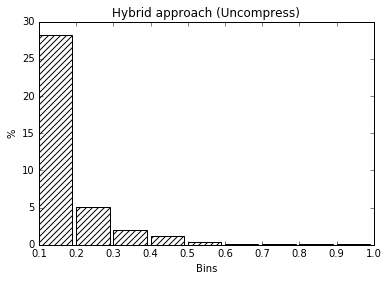

In [13]:
figure, ax = plt.subplots()
ax.bar(bins, frequencyCombinedUncompressWin, 0.09, color='w', hatch='////', label='Uncompress')
ax.set_xlim((0.1, 1.0))
ax.set_xlabel('Bins')
ax.set_ylabel('%')
ax.set_title('Hybrid approach (Uncompress)')
#ax[0].set_ylim((0, 30000))

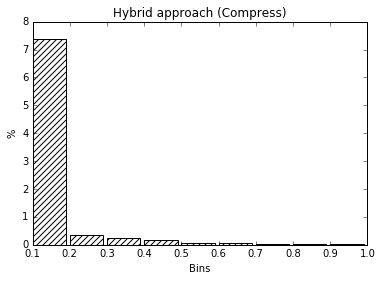

In [14]:
figure, ax = plt.subplots()
ax.bar(bins, frequencyCombinedCompressWin, 0.09, color='w', hatch='////', label='Compress')
ax.set_xlim((0.1, 1.0))
ax.set_xlabel('Bins')
ax.set_ylabel('%')
ax.set_title('Hybrid approach (Compress)')

In [19]:
print 'Bin\t\tUncompressWin\tCompressWin\tUncompressLose\tCompressLOse'
previousBin = 0.0
for unWin, coWin, unLose, coLose, bi in zip(frequencyCombinedUncompressWin, frequencyCombinedCompressWin,
                                           frequencyCombinedUncompressLose, frequencyCombinedCompressLose, bins):
    print '[%.1f, %.1f)\t%i\t\t%i' %(previousBin, bi, unWin, coWin, unLose, coLose)
    previousBin = bi

Bin		UncompressWin	CompressWin	UncompressLose	CompressLOse


TypeError: not all arguments converted during string formatting

In [12]:
print '%.3f' % ((frequencyCombinedCo.sum() / compressCombined['term'].count()) * 100)
print '%.3f' % ((frequencyCombinedUn.sum() / compressCombined['term'].count()) * 100)

8.361
18.696


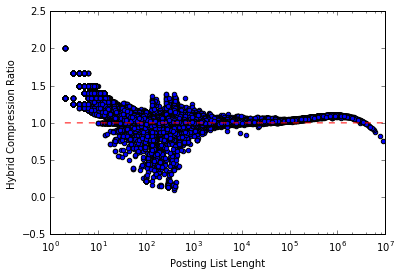

In [13]:
# Hybrid Compression Ratio: HybridCompression / PForCompression #

start = compressCombined.Li.min()
stop = compressCombined.Li.max()

s = np.arange(start, stop, 10, dtype=np.int64)
threshold = np.full((len(s)), 1.0, dtype=np.float16)

figure, ax = plt.subplots()
ax.plot(s, threshold, color='r', linestyle='--')
ax.scatter(compressCombined['Li'], compressCombined['Combined_Co'])

ax.set_xlabel('Posting List Lenght')
ax.set_ylabel('Hybrid Compression Ratio')
ax.set_xscale('log')
#ax.set_yscale('log')

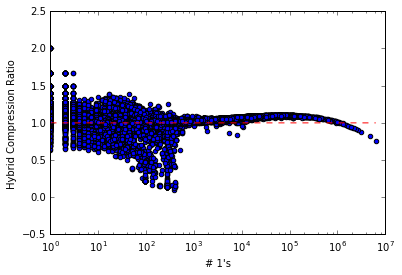

In [14]:
start = compressCombined['1s'].min()
stop = compressCombined['1s'].max()

s = np.arange(start, stop, 10, dtype=np.int64)
threshold = np.full((len(s)), 1.0, dtype=np.float16)

figure, ax = plt.subplots()
ax.plot(s, threshold, color='r', linestyle='--')
ax.scatter(compressCombined['1s'], compressCombined['Combined_Co'])
ax.set_xlabel('# 1\'s')
ax.set_ylabel('Hybrid Compression Ratio')
ax.set_xscale('log')

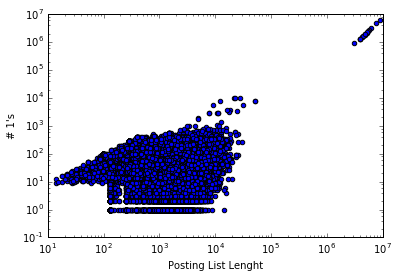

In [15]:
#compressCombinedClean = compressCombined[compressCombined['Li'] < 3.0]
combinedCoWin = compressCombined[compressCombined['Combined_Co'] < 1.0]

figure, ax = plt.subplots()
ax.scatter(combinedCoWin['Li'], combinedCoWin['1s'])
ax.set_xlabel('Posting List Lenght')
ax.set_ylabel('# 1\'s')
ax.set_xscale('log')
ax.set_yscale('log')

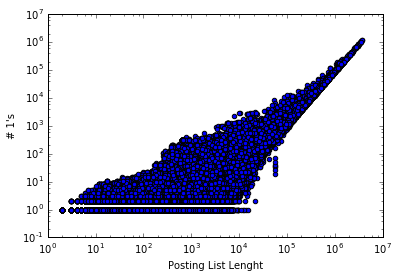

In [16]:
combinedCoLost = compressCombined[compressCombined['Combined_Co'] >= 1.0]

figure, ax = plt.subplots()
ax.scatter(combinedCoLost['Li'], combinedCoLost['1s'])
ax.set_xlabel('Posting List Lenght')
ax.set_ylabel('# 1\'s')
ax.set_xscale('log')
ax.set_yscale('log')

(0.0, 1.1)

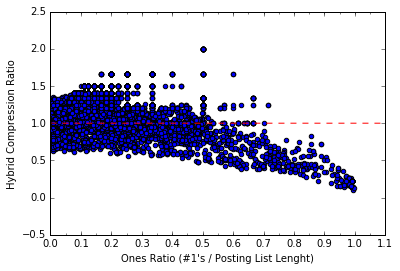

In [17]:
# How many ones do I need to win? #
# X-axis : One's proportion respect to Posting List Length #
# Y-axis : Hybrid Compression Ratio: HybridCompression / PForCompression #

start = 0.0
stop = 1.1

size = compressCombined['term'].count()

s = np.linspace(start, stop, size, dtype=np.float32)
threshold = np.full((len(s)), 1.0, dtype=np.float32)
onesRatio = compressCombined['1s'] / compressCombined['Li']

figure, ax = plt.subplots()
ax.scatter(onesRatio, compressCombined['Combined_Co'])
ax.plot(s, threshold, color='r', linestyle='--')
# Tickers #
min_x = MultipleLocator(0.05)
max_x = MultipleLocator(0.1)
ax.xaxis.set_major_locator(max_x)
ax.xaxis.set_minor_locator(min_x)
ax.set_xlabel('Ones Ratio (#1\'s / Posting List Lenght)')
ax.set_ylabel('Hybrid Compression Ratio')
ax.set_xlim([0.0, 1.1])

In [21]:
bins = np.array((.1, .2, .3, .4, .5, .6, .7, .8, .9, 1.), dtype=np.float64)
frequencyOnesRatioWin = np.zeros(10, dtype=np.float32)
frequencyOnesRatioLose = np.zeros(10, dtype=np.float32)

win = compressCombined.query('Combined_Co <= 1.0')
lose = compressCombined.query('Combined_Co > 1.0') # Ties Included! #

onesRatioWin = np.array(win['1s'] / win['Li'])
onesRatioLose = np.array(lose['1s'] / lose['Li'])

# Interval Type [) #
for idx in xrange(0, onesRatioWin.shape[0]):
    frequencyOnesRatioWin[bisect.bisect_right(bins, onesRatioWin[idx])] += 1
for idx in xrange(0, onesRatioLose.shape[0]):
    frequencyOnesRatioLose[bisect.bisect_right(bins, onesRatioLose[idx])] += 1

frequencyOnesRatioWin = (frequencyOnesRatioWin / compressCombined['term'].count()) * 100
frequencyOnesRatioLose = (frequencyOnesRatioLose / compressCombined['term'].count()) * 100

print 'Ones Ratio\tGanamos\t\tPerdemos/Empatamos'
previousBin = 0.0
for un, co, bi in zip(frequencyOnesRatioWin, frequencyOnesRatioLose, bins):
    print '[%.1f, %.1f)\t%.2f\t\t%.2f' %(previousBin, bi, un, co)
    previousBin = bi

Ones Ratio	Ganamos		Perdemos/Empatamos
[0.0, 0.1)	8.09		84.40
[0.1, 0.2)	1.05		3.34
[0.2, 0.3)	0.58		1.01
[0.3, 0.4)	0.36		0.37
[0.4, 0.5)	0.19		0.08
[0.5, 0.6)	0.07		0.22
[0.6, 0.7)	0.07		0.01
[0.7, 0.8)	0.04		0.00
[0.8, 0.9)	0.03		0.00
[0.9, 1.0)	0.08		0.00


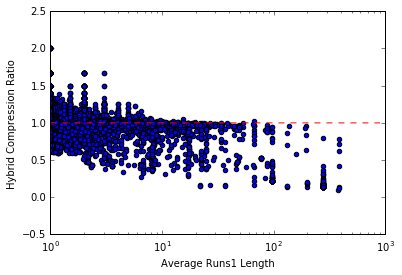

In [28]:
# What about 1's Runs? #
# X-axis : Average Run1 Length #
# Y-axis : Hybrid Compression Ratio: HybridCompression / PForCompression #

start = compressCombined['ar1l'].min()
stop = 900

size = compressCombined['term'].count()

s = np.linspace(start, stop, size, dtype=np.float32)
threshold = np.full((len(s)), 1.0, dtype=np.float16)

figure, ax = plt.subplots()
ax.plot(s, threshold, color='r', linestyle='--')
ax.scatter(compressCombined['ar1l'], compressCombined['Combined_Co'])
ax.set_xlabel('Average Runs1 Length')
ax.set_ylabel('Hybrid Compression Ratio')
ax.set_xscale('log')

In [35]:
bins = np.array((.1, .2, .3, .4, .5, .6, .7, .8, .9, 1.), dtype=np.float64)
frequencyAR1LWin = np.zeros(10, dtype=np.float64)
frequencyAR1LLose = np.zeros(10, dtype=np.float64)

ar1lWin = np.array(compressCombined.query('Combined_Co < 1.0')['ar1l'])
ar1lLose = np.array(compressCombined.query('Combined_Co >= 1.0')['ar1l']) # Ties Included! #

# Interval Type [) #
for idx in xrange(0, ar1lWin.shape[0]):
    frequencyAR1LWin[bisect.bisect_right(bins, ar1lWin[idx])] += 1
for idx in xrange(0, ar1lLose.shape[0]):
    frequencyAR1LLose[bisect.bisect_right(bins, ar1lLose[idx])] += 1

frequencyAR1LWin = (frequencyAR1LWin / compressCombined['term'].count()) * 100
frequencyAR1LLose = (frequencyAR1LLose / compressCombined['term'].count()) * 100

print 'AR1L\tGanamos\t\tPerdemos/Empatamos'
previousBin = 0.0
for un, co, bi in zip(frequencyAR1LWin, frequencyAR1LLose, bins):
    print '[%.1f, %.1f)\t%.2f\t\t%.2f' %(previousBin, bi, un, co)
    previousBin = bi

IndexError: index 10 is out of bounds for axis 0 with size 10

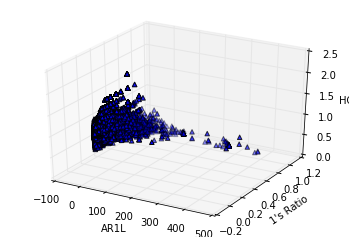

In [33]:
onesRatio = compressCombined['1s'] / compressCombined['Li']

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(compressCombined['ar1l'], onesRatio, compressCombined['Combined_Co'], marker='^')
ax.set_xlabel('AR1L')
ax.set_ylabel('1\'s Ratio')
ax.set_zlabel('HCR')

#ax.set_yscale('log')


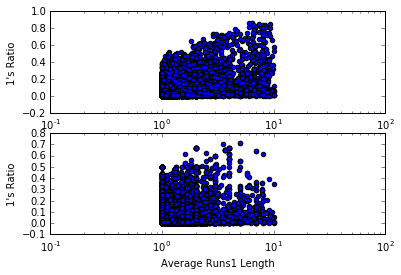

In [48]:
# AR1L : [10^0 - 10^1] #

win = compressCombined.query('(ar1l <= 10.0) & (Combined_Co < 1.0)')
loose = compressCombined.query('(ar1l <= 10.0) & (Combined_Co >= 1.0)')

onesRatioWin = win['1s'] / win['Li']
onesRatioLoose = loose['1s'] / loose['Li']

figure, ax = plt.subplots(2)
ax[0].scatter(win['ar1l'], onesRatioWin)
ax[0].set_xlabel('Average Runs1 Length')
ax[0].set_ylabel('1\'s Ratio')
ax[0].set_xscale('log')

ax[1].scatter(loose['ar1l'], onesRatioLoose)
ax[1].set_xlabel('Average Runs1 Length')
ax[1].set_ylabel('1\'s Ratio')
ax[1].set_xscale('log')

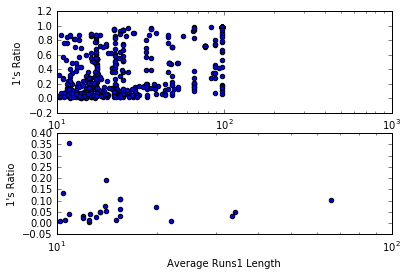

In [49]:
# AR1L : (10^1 - 10^2] #

win = compressCombined.query('(10.0 < ar1l <= 100.0) & (Combined_Co < 1.0)')
loose = compressCombined.query('(10.0 < ar1l <= 100.0) & (Combined_Co >= 1.0)')

onesRatioWin = win['1s'] / win['Li']
onesRatioLoose = loose['1s'] / loose['Li']

figure, ax = plt.subplots(2)
ax[0].scatter(win['ar1l'], onesRatioWin)
ax[0].set_xlabel('Average Runs1 Length')
ax[0].set_ylabel('1\'s Ratio')
ax[0].set_xscale('log')

ax[1].scatter(loose['ar1l'], onesRatioLoose)
ax[1].set_xlabel('Average Runs1 Length')
ax[1].set_ylabel('1\'s Ratio')
ax[1].set_xscale('log')

In [50]:
# AR1L : (10^2 - 10^3] #

win = compressCombined.query('(100.0 < ar1l <= 1000.0) & (Combined_Co < 1.0)')
loose = compressCombined.query('(100.0 < ar1l <= 1000.0) & (Combined_Co >= 1.0)')

onesRatioWin = win['1s'] / win['Li']
onesRatioLoose = loose['1s'] / loose['Li']

figure, ax = plt.subplots(2)
ax[0].scatter(win['ar1l'], onesRatioWin)
ax[0].set_xlabel('Average Runs1 Length')
ax[0].set_ylabel('1\'s Ratio')
ax[0].set_xscale('log')

ax[1].scatter(loose['ar1l'], onesRatioLoose)
ax[1].set_xlabel('Average Runs1 Length')
ax[1].set_ylabel('1\'s Ratio')
ax[1].set_xscale('log')


ValueError: Data has no positive values, and therefore can not be log-scaled.

ValueError: Data has no positive values, and therefore can not be log-scaled.

0.997435897436


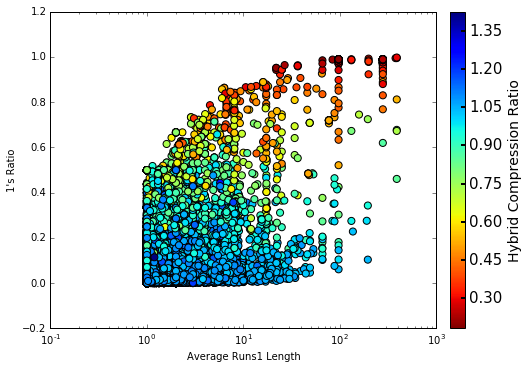

In [62]:
# http://eso-python.github.io/ESOPythonTutorials/ESOPythonDemoDay5_matplotlib_BerndHusemann_part2.html
#cmap=cm.RdBu_r
#cmap=cm.hsv_r
cmap=cm.jet_r
#figure, ax = plt.subplots(figsize=(7, 5))

plt.clf()
fig = plt.figure(figsize=(7,5))
ax = fig.add_axes([0.1,0.1,0.88,0.88])
scatter = ax.scatter(compressCombined['ar1l'], onesRatio, s=50, c=compressCombined['Combined_Co'], cmap=cmap)

cb = plt.colorbar(scatter, ax=ax, fraction=0.1, pad=0.03, aspect=20)
cb.ax.tick_params(width=2, labelsize=15)

cb.set_label('Hybrid Compression Ratio',fontsize=14)
ax.set_xlabel('Average Runs1 Length')
ax.set_ylabel('1\'s Ratio')

ax.set_xscale('log')